# Chapter 15 - Processing Sequence using RNN and CNN 

- RNN are not only types of neural network capable of handling sequence data. 
- RNN is like feedforward network except it has a connection backward 
- Output from RNN for single instance 
    $ y_{t} = \phi (W_{x}^{T} x_{t} + W_{y}^T y_{(t-1)} + b)$
- Many reachers prefer to use "tanh" activation function for RNN than ReLU function 

## Memory Cell 
- Output of each recurrent neuron at time step "t" is function of input from previous time step - you could say it is a memory. 
- A part of neural network that preserves some state across time step is called Memory Cell. 
- Single recurrent neuron is basic cell capable of learning only short patterns (about 10 steps long but varies depending on task)
- In general a cell state at anytime "t" is denoted as $h_{t}$ (hidden state)

## Input & Output Sequence 
- RNN can take sequence of input and produce sequence of output 
- Sequence to Sequence: network is useful in predicting timeseries such as stock market prices 
- Sequence to Vector: You can also feed network with series of input with output for last one; e.g. movie rating based on comments 
- Vector to Sequence: You can feed same input vector again and again and let output be the sequence; e.g. captioning an image
- Lastly we have sequence to vector network called encoders, followed by vector to sequence network called Decoders; used for translating one language to another. Encoder converts input in one language to vector and decoders convert vectorsto differnt language

## Training RNN on Time series 

In [9]:
from tensorflow import keras 
import tensorflow as tf
import numpy as np
import os 

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

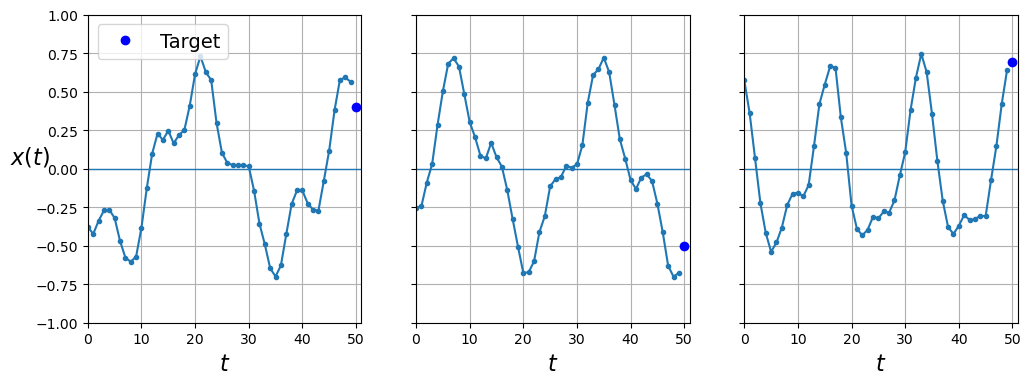

In [6]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

### Computing some baselines 

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2025-07-13 22:54:51.574293: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-13 22:54:51.574447: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-13 22:54:51.574458: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-13 22:54:51.574672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-13 22:54:51.574977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0.020211367

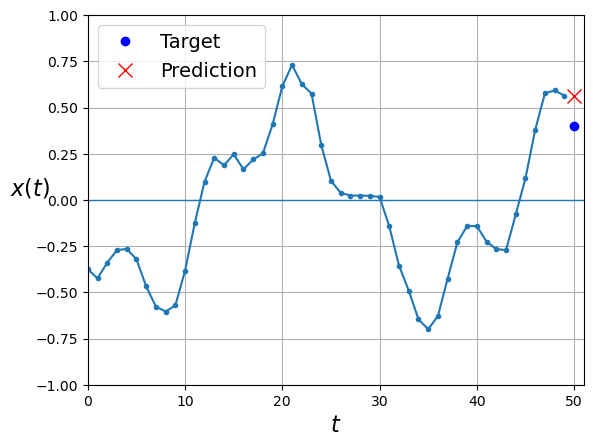

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Making prediction using linear regression 

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


2025-07-13 22:56:17.395553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 2s 6ms/step - loss: 0.0735 - val_loss: 0.0314
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0231 - val_loss: 0.0189
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 11/2

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0037


0.003668996272608638

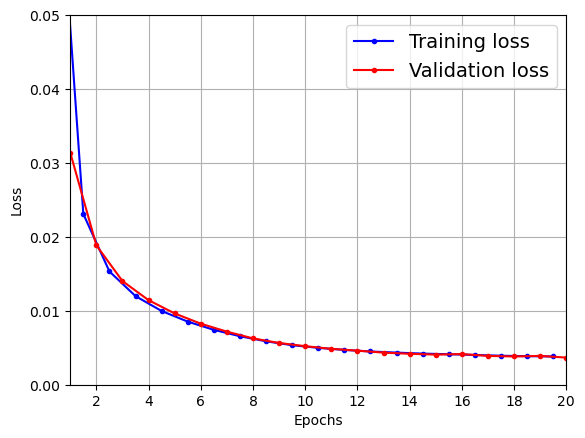

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 2ms/step


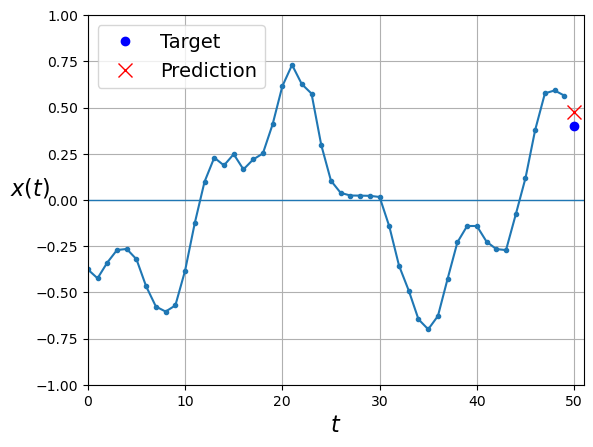

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using Simple RNN 

In [14]:
# this is the simplest RNN - single layer with single neuron. No need to specify length of input sequence
# by default simple RNN uses tanh activation function
# by default recurrent layers in keras only return final output. To make them output at every timestep, set return_sequence=True
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])



In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [16]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 240s 1s/step - loss: 0.2572 - val_loss: 0.1735
Epoch 2/20
219/219 [==============================] - 225s 1s/step - loss: 0.1147 - val_loss: 0.0730
Epoch 3/20
219/219 [==============================] - 220s 1s/step - loss: 0.0434 - val_loss: 0.0252
Epoch 4/20
219/219 [==============================] - 223s 1s/step - loss: 0.0170 - val_loss: 0.0129
Epoch 5/20
219/219 [==============================] - 223s 1s/step - loss: 0.0120 - val_loss: 0.0113
Epoch 6/20
219/219 [==============================] - 220s 1s/step - loss: 0.0116 - val_loss: 0.0111
Epoch 7/20
219/219 [==============================] - 788s 4s/step - loss: 0.0115 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 782s 4s/step - loss: 0.0115 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 185s 846ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 1430s 7s/step - loss: 0.0114 - va